# [LIGHTHOUSE] Desafio Ciência de Dados 2025-3
## Desafio:
Você foi alocado em um time da Indicium que está trabalhando atualmente junto a um cliente no processo de criação de uma plataforma de aluguéis temporários na cidade de Nova York.  
Para o desenvolvimento de sua estratégia de precificação, pediu para que a Indicium fizesse uma análise exploratória dos dados de seu maior concorrente, assim como um teste de validação de um modelo preditivo.  
Seu objetivo é desenvolver um modelo de previsão de preços a partir do dataset oferecido, e avaliar tal modelo utilizando as métricas de avaliação que mais fazem sentido para o problema

# Configuração do Ambiente

In [686]:
from sklearn.model_selection import train_test_split
from statsmodels.regression.linear_model import OLS
from sklearn.metrics import mean_squared_error
from statsmodels.tools import add_constant
from statsmodels.formula.api import ols
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
import statsmodels.api as sm
from typing import Dict
import pandas as pd
import numpy as np
import pickle
import math

# Entendendo o DataSet

Leitura do DataSet.

In [574]:
df = pd.read_csv('https://raw.githubusercontent.com/LuizGusQueiroz/Rental-Pricing/refs/heads/main/data.csv')

O DataSet contém registros de imóveis cadastrados na plataforma de aluguéis da concorrente, tendo as seguintes informações:  

| Coluna | Descrição |
| ------ | --------- |
| id | chave única para identificação do imóvel |
| nome | nome do imóvel |
| host_id | chave única para o anfitrião do imóvel |
| host_name | nome do anfitrião do imóvel |
| bairro_group | nome do bairro ao qual o imóvel pertence |
| bairro | nome do sub-bairro ao qual o imóvel pertence |
| latitude | latitude do imóvel |
| longitude | longitude do imóvel |
| room_type | tipo de quarto (Casa/apto inteiro, Quarto privado ou Quarto compartilhado)
| price | preço da diária |
| minimo_noites | mínimo de noites necessárias para alugar |
| numero_de_reviews | número de avaliações recebidas do imóvel |
| ultima_review | data da última avaliação recebida |
| reviews_por_mes | média de avaliações mensais |
| calculado_host_listintgs_count | número de imóveis anunciados pelo mesmo anfitrião |
| disponibilidade_365 | número de dias em que o imóvel estará disponível pelos próximos 365 dias |

In [575]:
# Visualizando uma amostra dos dados.
df.sample(5)

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
5950,4354764,A private humble abode for you,16572955,Sandra,Brooklyn,Canarsie,40.63969,-73.89548,Entire home/apt,90,2,112,2019-06-16,1.96,1,349
48803,36441908,Amazing flex room in financial district with view,112024431,Dariné,Manhattan,Financial District,40.70597,-74.01562,Private room,99,4,0,NaN,NaN,1,22
33157,26164606,Studio Apartment with Gorgeous View!,196660011,Ge,Manhattan,Harlem,40.81863,-73.95771,Entire home/apt,170,1,28,2018-11-28,2.20,1,0
6156,4503472,Park Slope Home away from Home,23353897,Barbara,Brooklyn,Park Slope,40.66763,-73.98156,Entire home/apt,163,4,58,2019-05-29,1.38,1,132
43554,33716426,Sonder | Stock Exchange | Central 1BR + Kitchen,219517861,Sonder (NYC),Manhattan,Financial District,40.70723,-74.01086,Entire home/apt,229,2,3,2019-06-13,1.55,327,340


# Limpeza e Pré-processamento dos Dados

Várias linhas contém valores nulos, para não gerar problemas nas análises, será analisado como os valores nulos estão distribuídos.

In [576]:
# Realiza a contagem de valores nulos em cada coluna do DataFrame.
for column in df.columns:
    nulos = len(df[df[column].isna()])
    print(f'{column}: {nulos}')

id: 0
nome: 16
host_id: 0
host_name: 21
bairro_group: 0
bairro: 0
latitude: 0
longitude: 0
room_type: 0
price: 0
minimo_noites: 0
numero_de_reviews: 0
ultima_review: 10052
reviews_por_mes: 10052
calculado_host_listings_count: 0
disponibilidade_365: 0


Há alguns registros com o nome ou o host_name como nulo, como não há como deduzir estas informações, será apenas colocado um nome default.   
Já em registros sem reviews, os valores de 'ultima_review' e 'reviews_por_mes' ficam como nulo, em última review, não há oque fazer pois não se pode definir uma data zero como última review, mas em reviews por mês, é possível estabelecer como substituto aos nulos, o valor 0.

In [577]:
# Substitui valores nulos na coluna selecionada por 0.
df['reviews_por_mes'].fillna(0, inplace=True)

<ipython-input-577-85ffe515df77>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['reviews_por_mes'].fillna(0, inplace=True)


In [578]:
df['nome'].fillna('nameless', inplace=True)

<ipython-input-578-1a5f91c95c58>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['nome'].fillna('nameless', inplace=True)




---



Apesar de não ser um valor nulo, há alguns imóveis com valor de aluguel igual a 0.

In [579]:
df[df['price']==0].sample()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
25777,20624541,Modern apartment in the heart of Williamsburg,10132166,Aymeric,Brooklyn,Williamsburg,40.70838,-73.94645,Entire home/apt,0,5,3,2018-01-02,0.15,1,73


Estes casos provavelmente são erros e não fazem sentido para esta análise, por isto, serão descartados.

In [580]:
df = df[df['price']!=0]



---



A coluna 'ultima_review' têm as datas como string, estas serão convertidas para datetime para melhor manipulação das datas.

In [581]:
df['ultima_review'] = pd.to_datetime(df['ultima_review'], format='%Y-%m-%d', errors='coerce')

<ipython-input-581-25f6b766bc1e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ultima_review'] = pd.to_datetime(df['ultima_review'], format='%Y-%m-%d', errors='coerce')




---



Ao final deste estudo, será utilizado o modelo desenvolvido para prever o valor do preço do imóvel com id 2595. Para não influenciar na decisão, este imóvel será removido do conjunto de dados.

In [582]:
imovel_2595 = df[df['id']==2595]
imovel_2595

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355


In [583]:
# Remove o registro com id = 2595 do DataSet.
df.drop(df[df['id']==2595].index, axis='index', inplace=True)

# Análise Exploratória dos Dados (EDA)

## Temos 4 tipos de dados no DataSet:

*   Categóricos:
    *   bairro_group
    *   bairro
    *   room_type
    *   id
    *   nome
    *   host_id
    *   host_name

*   Numéricos:
    *   price
    *   minimo_noites
    *   numero_de_reviews
    *   reviews_por_mes
    *   calculado_host_listings_count
    *   disponibilidade_365

* Temporais:
    *   ultima_review

* Geográficos:
    *   latitude
    *   longitude


Entretando nem todos trazem informações importantes, como id, host_id e host_name. Estes serão deixados de lado nas análises.

---

## Variáveis categóricas

Para as variáveis categóricas, uma ótima forma de ver como os valores estão distribuídos é através de um gráfico de colunas, que permite visualizar a ocorrência de cada valor.  
Quando existem muitas categorias, a visualização fica difícil, então são selecionados apenas uma parte dos valores mais ocorrentes para a visualiação.

In [584]:
def barhplot(df: pd.DataFrame, column: str, ax: plt.Axes, title: str, max: int=-1) -> None:
    # Realiza a contagem de cada valor existente na coluna de maneira ordenada.
    contagem = df[column].value_counts().iloc[:max]
    # Plota um gráfico de barras horizontais a partir dos valores de contagem.
    ax.barh(contagem.index, contagem.values)
    # Adiciona a porcentagem de cada valor ao final da barra.
    for i, valor in enumerate(contagem.values):
        # na coluna 'nome' será exibida a contagem ao invés da porcentagem, pois é um dado mais explicativo.
        if column == 'nome':
            ax.text(valor + 0.1, i, valor, va='center')
        # nos demais casos, será exibida a porcentagem
        else:
            porcentagem = (valor / df.shape[0]) * 100
            ax.text(valor + 0.1, i, f'{porcentagem:.2f}%', va='center')
    # inverte o eixo y, para que os valores estejam em ordem decrescente.
    ax.invert_yaxis()
    ax.set_xlabel('Ocorrência')
    ax.set_title(title)

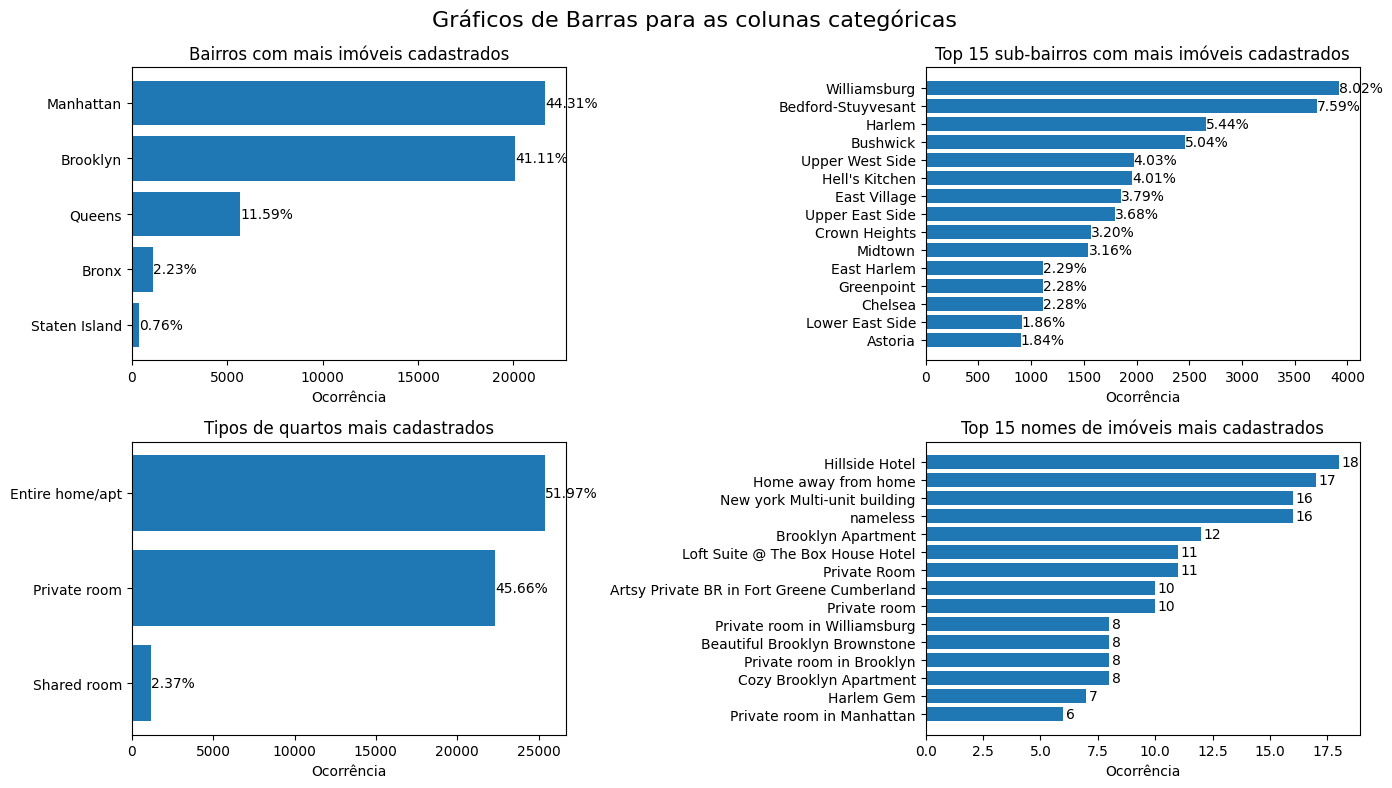

In [585]:
fig, axs = plt.subplots(2, 2, figsize=(14, 8))
axs = axs.flatten()

columns = ['bairro_group', 'bairro', 'room_type', 'nome']
titles = ['Bairros com mais imóveis cadastrados', 'Top 15 sub-bairros com mais imóveis cadastrados',
          'Tipos de quartos mais cadastrados', 'Top 15 nomes de imóveis mais cadastrados']
for i, column, title in zip(range(4), columns, titles):
    barhplot(df, column, axs[i], title, 15)

plt.suptitle('Gráficos de Barras para as colunas categóricas', fontsize=16)
plt.tight_layout()
plt.show()

### Insights

#### Bairros com mais imóveis
Temos 5 bairros em Nova York: Manhattan, Brooklyn, Queens, Bronx e Staten Island.  
Porem, só os bairros Manhattan e Brooklyn contém mais de 85% dos imóveis cadastrados, e se somados ao Queens, contém mais de 97% dos imóveis, mostrando uma forte concentração nestes bairros.

#### Sub-bairros com mais imóveis
Há 221 sub-bairros no DataSet, porém, ao somar os 5 sub-bairros com mais imóveis, vamos encontrar mais de 30% dos imóveis cadastrados, e somando os 15 primeiros, encontramos 58.5% dos imóveis cadastrados.  
Dentre estes 15 bairros,

*   9 estão em Manhattan
*   5 estão no Brooklyn
*   1 está no Queens

Uma representação bem fiel da disparidade de imóveis cadastrados em cada bairro.


#### Tipos de quartos mais cadastrados
Entre os tipos de quartos, o mais frequente é o aluguel da casa/apt inteiro, e bem próximo, aluguel de apenas um quarto privado. É possível notar também que quartos compartilhados não são muito frequentes, sendo apenas 2.3% dos imóveis.


#### Nomes de imóveis mais cadastrados
Entre os nomes mais cadastrados, não há nenhum valor discrepante dos demais, apenas um grupo dos 3 nomes mais comuns mais a frente dos demais.



---



## Variáveis numéricas

Já para as variáveis numéricas, existem 2 gráficos principais para visualizar a distribuição dos dados, o histograma que define intervalos e faz um gráfico de colunas, tendo como categorias, os intervalos definidos, e o boxplot, que mostra dentre quais valores, os dados estão concentrados.  


No histograma, valores extremos podem atrapalhar na criação das categorias, então se forem poucos valores extremos, estes podem ser desconsiderados na visualização.

In [586]:
def hist(df: pd.DataFrame, column: str, ax: plt.Axes, title: str, xlim: float, bins: int=35) -> None:
    # Filtra os valores da coluna menores que um limite, para evitar que
    # outliers atrapalhem a visualização.
    data = df[df[column] < xlim][column]
    ax.hist(data, bins)

    q2 = df[column].quantile(0.5) + 0.5
    q3 = df[column].quantile(0.75) + 0.5
    # Adiciona linhas para o q2 e o q3.
    ax.axvline(q2, color='r')
    ax.axvline(q3, color='g')

    ax.set_ylabel('Ocorrência')
    ax.set_title(title)

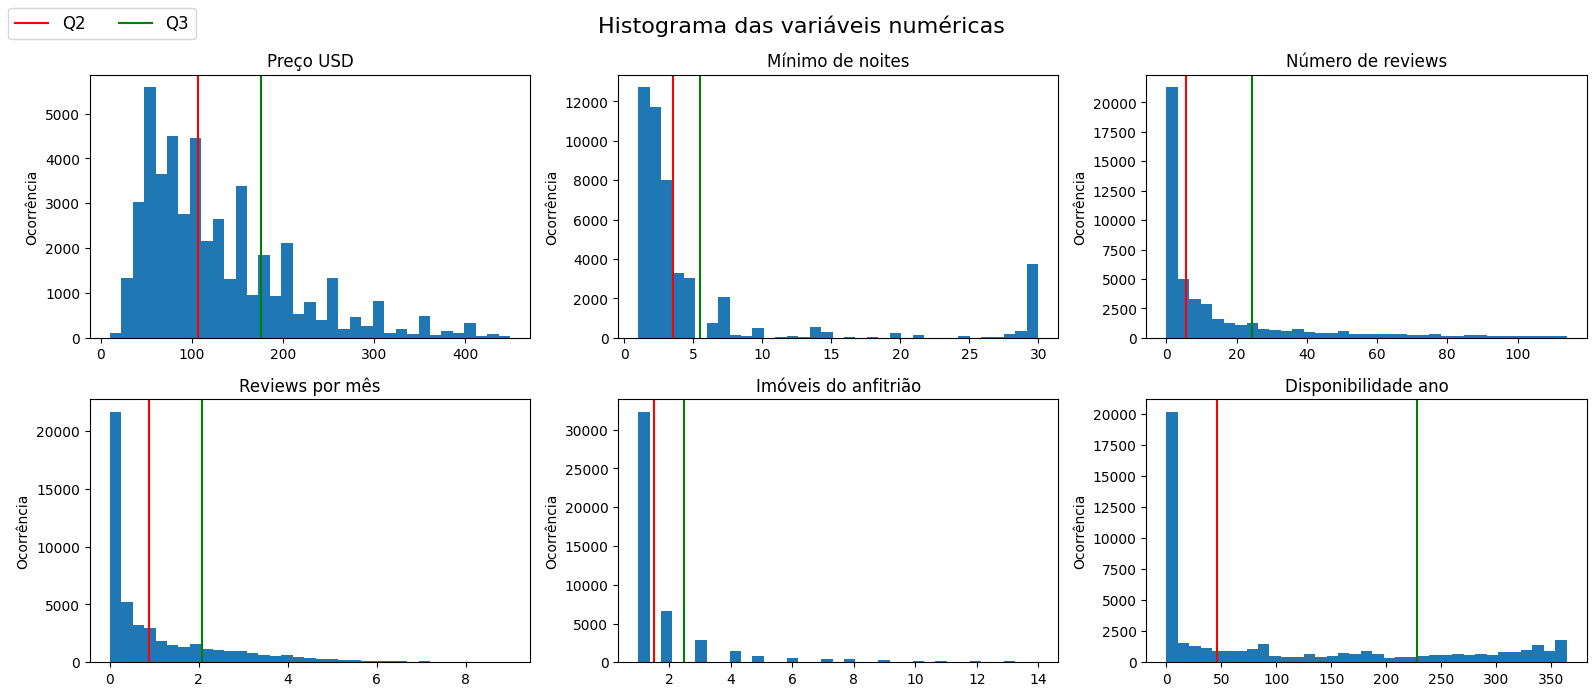

In [587]:
fig, axs = plt.subplots(2, 3, figsize=(16, 7))
axs = axs.flatten()
#          i    coluna                              título            xlim
params = [[0, 'price',                         'Preço USD',                450],
          [1, 'minimo_noites',                 'Mínimo de noites',      31],
          [2, 'numero_de_reviews',             'Número de reviews',    115],
          [3, 'reviews_por_mes',               'Reviews por mês',        9],
          [4, 'calculado_host_listings_count', 'Imóveis do anfitrião',  15],
          [5, 'disponibilidade_365',           'Disponibilidade ano',  365]
]

for i, column, title, xlim in params:
    hist(df, column, axs[i], title, xlim)

# Adiciona o subtítulo.
plt.suptitle('Histograma das variáveis numéricas', fontsize=16)
# Adicona a legenda dos quantis.
fig.legend(['Q2', 'Q3'], loc='upper left', fontsize=12, ncol=2)
plt.tight_layout()
plt.show()

### Insights














**OBS**: Em todos os gráficos, foi representado mais de 95% do conjunto dos dados, portanto, a remoção de outliers não afeta a fidelidade dos gráficos em relação aos dados.

In [588]:
for _, column, _, xlim in params:
    porcentagem = round(100* (df[column]<=xlim).mean(), 2)
    print(f'{column.ljust(30)}: {porcentagem}%')

price                         : 97.05%
minimo_noites                 : 98.88%
numero_de_reviews             : 95.11%
reviews_por_mes               : 99.7%
calculado_host_listings_count : 95.09%
disponibilidade_365           : 100.0%


#### Preço
É possível notar que a maioria dos preços está abaixo de 200, sendo o Q3 (linha verde) inferior a 200, ou seja, 75% dos preços estão abaixo de 200, e mais concentrados ainda estão os valores abaixo de 100, que contém quase 50% dos preços.

#### Mínimo de noites
Em mais de 75% dos imóveis, o mínimo de noites é no máximo 5, para os demais valores, percebe-se uma redução, no entanto há um pico onde o mínimo de noites são 30, aproximadamente 4000 imóveis.

#### Número de reviews
50% dos imóveis tem 0 ou 1 avaliações, indicando que as pessoas tendem a alugar imóveis com um histórico maior de uso.
Em seguida, a distribuição do número de reviews se dispersa, estando o Q2 em aproximadamente 25 reviews.

#### Reviews por mês
50% dos imóveis tem menos de 1 review por mês, e 75% tem menos de 2 reviews por mês, mostrando que muitos imóveis não estão sendo utilizados.

#### Imóveis do anfitrião
Em mais 50% dos imoveis, o anfitrião só tem imóvel anunciado, e em 75%, o anfitrião tem no máximo 2 imóveis anunciados, mostrando que a maioria dos anfitriões são provavelmente pessoas físicas que não tem no aluguel de imóveis sua principal fonte de renda.

#### Disponibilidade ano
50% dos imóveis está disponível em apenas 50 dos próximos 365 dias, provavelmente pessoas que irão viajar nas férias e querem deixar a casa alugada no período e 75% estará disponível em aproximadamente 230 dias, neste caso, provavelmente há muitas pessoas que utilizam do imóvel como estadia no período de férias, mas quando estão fora, deixam o imóvel disponível para aluguel.

---

## Variáveis Temporais

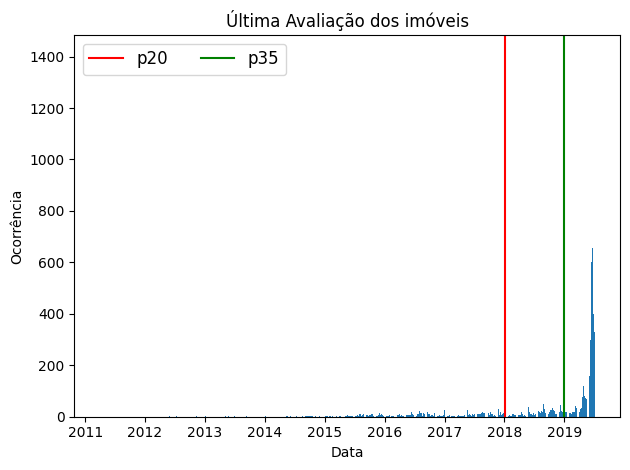

In [589]:
contagem = df['ultima_review'].value_counts()
plt.bar(contagem.index, contagem.values)

p20 = df['ultima_review'].quantile(0.2)
p35 = df['ultima_review'].quantile(0.35)
plt.axvline(p20, color='r')
plt.axvline(p35, color='g')

plt.legend(['p20', 'p35'], loc='upper left', fontsize=12, ncol=2)
plt.xlabel('Data')
plt.ylabel('Ocorrência')
plt.title('Última Avaliação dos imóveis')
plt.tight_layout()
plt.show()

#### Última Avaliação
A váriavel 'última avaliação dos imóveis' está concentrada acima de 2018, e mais ainda acima de 2019, tendo 80% dos valores acima de 2018, e 65% acima de 2019, estando os demais valores espalhados entre 2011 e 2017.

## Variáveis Geométricas

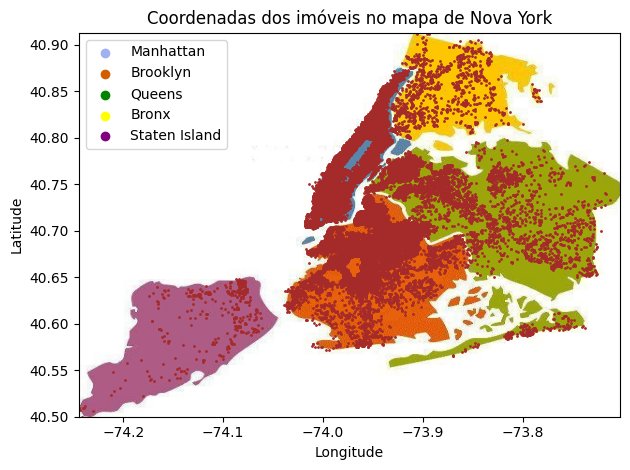

In [590]:
# Acessa a imagem.
img = mpimg.imread('mapa.jpg')

fig, ax = plt.subplots()
# Define os limites da imagem.
x_min, x_max = df['longitude'].min(), df['longitude'].max() + 0.01  # Pequeno ajuste no x_max para esticar um pouco a imagem.
y_min, y_max = df['latitude'].min(), df['latitude'].max()
# Coloca a imagem no fundo do gráfico.
ax.imshow(img, extent=[x_min, x_max, y_min, y_max], aspect='auto')
# Plota o gráfico de dispersão.
ax.scatter(df['longitude'], df['latitude'], s=1, c='brown')
# Adicona a legenda.
# Define as cores para os bairros
cores = ['#A0B0F0', '#D35D00', '#008400', 'yellow', 'purple']
bairros = ['Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island']

# Adiciona a legenda criando pontos invisíveis com cores
for cor, bairro in zip(cores, bairros):
    ax.scatter([], [], c=cor, label=bairro)

# Adiciona a legenda
ax.legend(loc='best')

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Coordenadas dos imóveis no mapa de Nova York')
plt.tight_layout()
plt.show()

Analisando o gráfico de dispersão, percebe-se uma concentração significativa nos bairros: Manhattan, Queens e Brooklyn, fundamentando o que foi apresentado no gráfico de barras 'Bairros com Mais Imóveis Cadastrados'.

## Verificando a correlação entre as variáveis

<ipython-input-591-4605ca700ba6>:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 640x480 with 0 Axes>

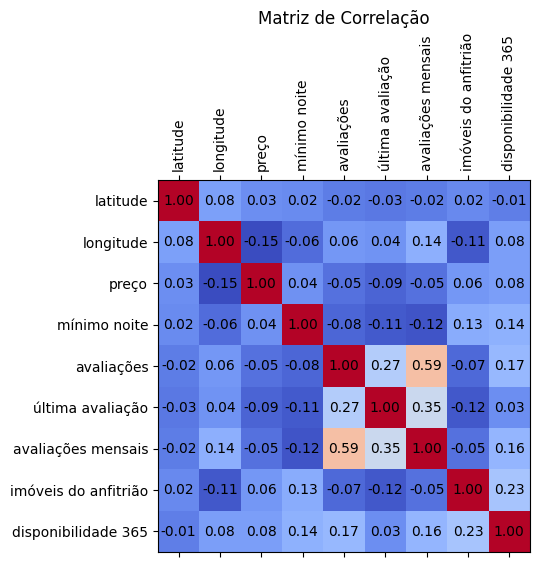

In [591]:
plt.figure()
corr = df.drop(['id', 'nome', 'host_id', 'host_name','bairro_group', 'bairro', 'room_type'], axis='columns').corr()
corr.columns = ['latitude', 'longitude', 'preço', 'mínimo noite', 'avaliações', 'última avaliação', 'avaliações mensais',
                'imóveis do anfitrião', 'disponibilidade 365']
# Exibe a matriz de correlação como uma imagem
cax = plt.matshow(corr, cmap='coolwarm')

plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)

# Adiciona os valores de correlação como anotações
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        plt.text(j, i, f'{corr.iloc[i, j]:.2f}', ha='center', va='center', color='black')

plt.title('Matriz de Correlação')
plt.tight_layout()
plt.show()

É possível ver que as variáveis que mais se relacionam entre si são:
* avaliações mensais x avaliações (0.59)
* avaliações mensais x última avaliação (0.35)
* última avaliação x avaliações (0.27)
Oque faz sentido, já que todas se referem ao mesmo assunto.

Ao que se refere ao preço, oque as variáveis mais relacionadas com o preço são:
* longitude (-0.15)
* última avaliação (-0.09)
* disponibilidade 365 (0.08)

# Engenharia de Features

## Categorização

In [592]:
def categoriza(df: pd.DataFrame, column: str, max_intervalos: int = 10) -> list[float]:
    quantis = [-1] + [df[column].quantile(i/max_intervalos) for i in range(1, max_intervalos)] + [float('inf')]
    # Há casos onde dois quantis resultam no mesmo valor, isto causará problemas no corte do DataFrame.
    quantis = sorted(list(set(quantis)))
    # Categoriza a coluna.
    df[f'{column}_cat'] = pd.cut(df[column], quantis, labels=range(1, len(quantis)))
    return quantis

In [593]:
intervalos = {}
for column in ['minimo_noites', 'numero_de_reviews', 'reviews_por_mes',
               'calculado_host_listings_count', 'disponibilidade_365']:
    intervalos[column] = categoriza(df, column, 15)

## Log
Para variáveis que estão distribuídas assimetricamentes, com uma cauda longa à direita e com uma escala de valores bem diferentes, a aplicação do log pode ser útil para  normalizar os valores.

In [594]:
columns = ['minimo_noites', 'numero_de_reviews',  'reviews_por_mes',  'calculado_host_listings_count', 'disponibilidade_365']
for column in columns:
    df[f'Log-{column}'] = np.log(df[column]+1)

## Dias sem review
A data da última review pode ser simplificada criando uma coluna que conta quantos dias o imóvel está sem avaliações, tendo como base o 'hoje' como a review mais recente, para que imóveis com última avaliação igual a mais recente, terem 0 dias sem review.

In [595]:
mais_recente = df['ultima_review'].max()
df['dias_sem_review'] = (mais_recente - df['ultima_review']).dt.days.fillna(0)

## Custo Mínimo de Estadia
Pode ser interessante criar uma variável que calcula o custo mínimo de uma estadia, sendo o resultado do produto do custo da diária pelo mínimo de noites.

In [596]:
df['custo_min_estadia'] = df['price'] * df['minimo_noites']

## Imóveis do anfitrião no mesmo bairro
Outro fator que pode influenciar no preço, é o total de imóveis que um anfitrião tem cadastrado no mesmo bairro.

In [597]:
df['imoveis_host_no_bairro'] = df.groupby(['host_id', 'bairro'])['id'].transform('count')

## Distância do maior ponto turístico do bairro
Um dos fatores que mais deve influenciar no preço do aluguel, é a distância para o maior ponto turístico do bairro, sendo estes:
*   Manhattan: Central Park
    *   Latitude: 40.785091
    *   Longitude: -73.968285

*   Brooklyn: Brooklyn Bridge
    *   Latitude: 40.706086
    *   Longitude: -73.996864

*   Queens: Flushing Meadows-Corona Park
    *   Latitude: 40.749824
    *   Longitude: -73.840785

*   Bronx: Bronx Zoo
    *   Latitude: 40.850596
    *   Longitude: -73.876998

*   Staten Island: Staten Island Ferry
    *   Latitude: 40.644167
    *   Longitude: -74.072222

In [598]:
# Não é necessário identificar qual é qual, apenas os pares precisam estar corretos.
latitudes  =  40.785091,  40.706086,  40.749824,  40.850596,  40.644167
longitudes = -73.968285, -73.996864, -73.840785, -73.876998, -74.072222

In [599]:
def min_dist(row, latitudes, longitudes) -> float:
    """
    Retorna a menor distância entre o ponto e as corrdenadas dos principais pontos
    turísticos do bairro com a função math.dist().
    """
    return min([math.dist([row['latitude'], row['longitude']], [lat, lon])
                              for lat, lon in zip(latitudes, longitudes)])

In [600]:
df['dist_principal'] = df.apply(lambda row: min_dist(row, latitudes, longitudes), axis=1)

## Tem avaliações
Este será um indicador se o imóvel contém ou não avaliações, sendo 0 se o imóvel tem 0 avaliações, e 1 caso contrário.

In [601]:
df['tem_review'] = (df['numero_de_reviews'] > 0).astype(int)

## Meses de cadastro
O tempo de cadastro do imóvel será estimado através do total de reviews e as reviews por mês, já que:  
$reviews\_por\_mes = \frac{total\_reviews}{meses\_cadastrado} $  
então:  
$meses\_cadastrado = \frac{total\_reviews}{reviews\_por\_mes}$

**obs**: Isto é apenas uma estimação.

In [602]:
df['meses_cadastrado'] = (df['numero_de_reviews'] / df['reviews_por_mes']).fillna(1)

## Tipo de Quarto x Bairro
Pode haver diferenciação do tipo de quarto dependendo do bairro, então serão criadas colunas de cada tipo de quarto para cada bairro.

In [603]:
df['room_type'].unique()

array(['Private room', 'Entire home/apt', 'Shared room'], dtype=object)

In [604]:
tipos = ['Private room', 'Shared room']
bairros = ['Staten Island', 'Brooklyn', 'Queens', 'Bronx']
for tipo in tipos:
    for bairro in bairros:
        df[f'{tipo}_{bairro}'] = ((df['room_type'] == tipo) & (df['bairro_group'] == bairro)).astype(int)

Engenharia de Features Objetivo: Criar variáveis (features) que melhor representam o problema para o modelo.
Atividades:

Selecionar e transformar variáveis.

Criar novas features a partir dos dados existentes.

Reduzir dimensionalidade (se necessário).

# Perguntas

## Supondo que uma pessoa esteja pensando em investir em um apartamento para alugar na plataforma, onde seria mais indicada a compra?

Na hora de alugar um apartamento, os dois fatores principais a se levar em conta seriam o preço e a localização.
Agrupando os custos mínimos de estadia por bairro, e calculando a mediana (para evitar que valores extremos influenciem na decisão), temos os seguintes resultados:

In [605]:
df.groupby('bairro_group')['custo_min_estadia'].median().sort_values(ascending=False)

,custo_min_estadia
bairro_group,
Manhattan,440.0
Brooklyn,266.0
Queens,160.0
Staten Island,158.0
Bronx,149.5


Temos 3 bairros com mediana de custo mínimo bem próximos e dois bem acima dos demais, nestas condições, seria indicado alugar no Queens, pois está bem próximo do preço de Staten Island e Bronx, mas é bem mais centralizado que os demais, estando inclusive, bem próximo de Manhattan, que é o principal bairro.

## O número mínimo de noites e a disponibilidade ao longo do ano interferem no preço?

Através da matriz de correlação exibida exibida anteriormente, foi possível ver que:
* mínimo de noites x preço, tem correlação 0.04
* disponibilidade 365 x preço, tem correlação 0.08
Indicando que ambos praticamente não influenciam no preço.
Esta informação pode ser constatada através de um gráfico de dispersão:

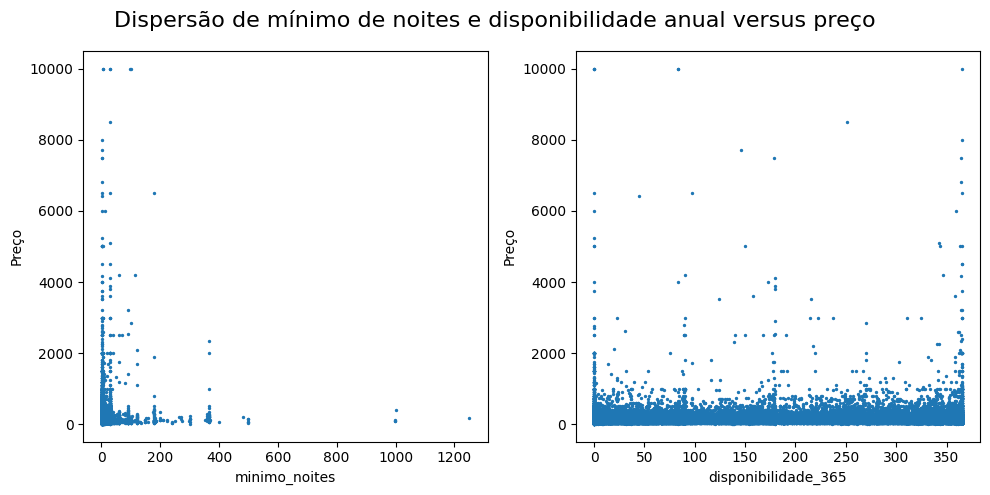

In [606]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs = axs.flatten()

for i, column in enumerate(['minimo_noites', 'disponibilidade_365']):
    axs[i].scatter(df[column], df['price'], s=2)
    axs[i].set_xlabel(column)
    axs[i].set_ylabel('Preço')


# Adiciona o subtítulo.
plt.suptitle('Dispersão de mínimo de noites e disponibilidade anual versus preço', fontsize=16)
plt.tight_layout()
plt.show()

Novamente é possível ver a ausência de relação entre mínimo de noites e disponibilidade anual com o preço.

## Existe algum padrão no texto do nome do local para lugares de mais alto valor?


In [607]:
def count_words(texts):
    words = []
    for text in texts:
        words.extend(text.lower().split())
    return Counter(words)

In [608]:
# Porcentagem de valores abaixo da divisória.
# Ex: p=90: 90% dos valores serão consierados de preço normal, e os 10% maiores serão de alto preço.
p = 90
lim = df['price'].quantile(p/100)
df['alto_preco'] = (df['price'] < lim).astype(int)

# Separando os nomes de alto e baixo preço.
alto_preco = df[df['alto_preco'] == 1]['nome']
baixo_preco = df[df['alto_preco'] == 0]['nome']
# Contagem das palavras.
count_alto = count_words(alto_preco)
count_baixo = count_words(baixo_preco)
# Deixa a contagem de maneira proporcional à quantidade de imóveis analisadas em cada caso.
count_alto_prop = Counter({word: round(count / len(alto_preco), 3) for word, count in count_alto.items()})
count_baixo_prop = Counter({word: round(count / len(baixo_preco), 3) for word, count in count_baixo.items()})

print('Top 10 palavras mais comuns em imóveis com:')
print('Alto valor', ' '*10, 'Baixo Valor')
for i, j in zip(count_alto_prop.most_common(10), count_baixo_prop.most_common(10)):
    print(str(i).ljust(21), j)

Top 10 palavras mais comuns em imóveis com:
Alto valor            Baixo Valor
('in', 0.353)         ('in', 0.245)
('room', 0.211)       ('2', 0.137)
('private', 0.153)    ('bedroom', 0.126)
('bedroom', 0.15)     ('apartment', 0.105)
('apartment', 0.127)  ('luxury', 0.092)
('cozy', 0.102)       ('loft', 0.083)
('to', 0.081)         ('apt', 0.082)
('studio', 0.081)     ('the', 0.082)
('the', 0.079)        ('village', 0.071)
('brooklyn', 0.077)   ('with', 0.071)


In [609]:
for termo in ['room', 'private', 'cozy']:  # Ocorrência de alguns termos em imóveis de baixo valor.
    print(f'{termo.ljust(7)}: {round(100*count_baixo_prop[termo], 2)}%')

room   : 2.4%
private: 5.0%
cozy   : 2.7%


* O termo 'in' é bem mais utilizado em imóveis de alto valor quando comparado aos de baixo valor, sendo utilizado em 35% dos nomes em imóveis de alto valor, contra 26% nos de baixo, indicando que provavelmente, imóveis com nomes compostos sejam mais caros.  
* O termo 'room', aparecendo em 21% dos imóveis de alto valor, aparece em menos de 2% dos imóveis de baixo valor, é a maior diferença proporcional.
* Em seguida, o termo 'private', com frequência de 16% em imóveis de alto valor aparece apenas em 5.6% nos ióveis de baixo valor.
* O último termo que difere bastante proporcionalmente é o 'cozy', ocorrendo em 10.8% dos imóveis de alto valor e em 3.2% dos imóveis de baixo valor.

### Nuvem de palavras de imóveis de alto valor

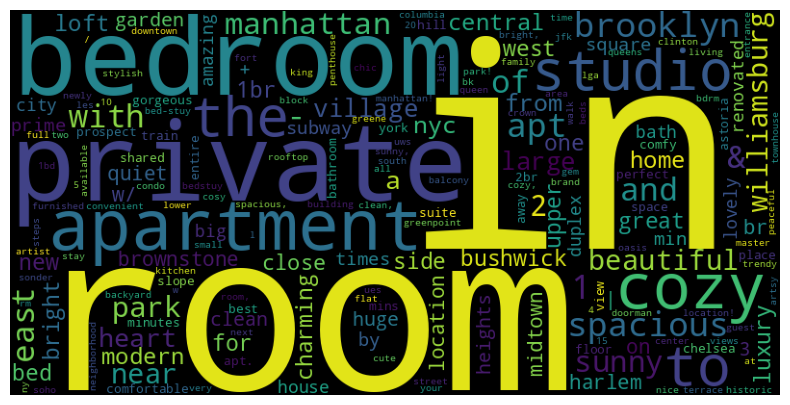

In [610]:
wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(count_alto)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Nuvem de palavras de imóveis de baixo valor

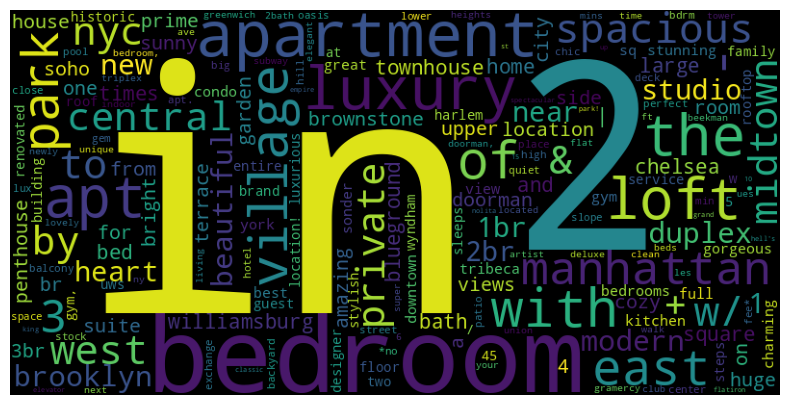

In [611]:
wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(count_baixo)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Modelo

O modelo a ser utilizado será a regressão linear múltipla, com os mínimos quadrados, pois é um método simples, bastante intuitivo e é fácil explicar os seus resultados, além de que é bem eficiente computacionalmente.  
Só foi preciso realizar alguns tratamentos para cuidar dos outliers e da multicolineariedade, que são bem problemáticos para este modelo.

In [623]:
# Definindo as colunas que serão utilizadas no modelo.
X = add_constant(df[['bairro_group', 'room_type', 'minimo_noites_cat', 'numero_de_reviews_cat',
                     'calculado_host_listings_count_cat', 'disponibilidade_365_cat',
                     'dist_principal', 'meses_cadastrado']])
# Aplicando o one-hot-encoding nas variáveis categóricas.
X = pd.get_dummies(X, columns=['bairro_group', 'room_type'], drop_first=True).astype(float)
# Definindo a coluna alvo.
y = df['price']

In [624]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Ajustar o modelo nos dados de treino
modelo = sm.OLS(y_train, X_train)
resultado = modelo.fit()

# Exibir resumo do modelo
print(resultado.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     373.9
Date:                Tue, 04 Feb 2025   Prob (F-statistic):               0.00
Time:                        23:52:25   Log-Likelihood:            -2.6803e+05
No. Observations:               39105   AIC:                         5.361e+05
Df Residuals:                   39092   BIC:                         5.362e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [685]:
y_pred = resultado.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

mse

48190.263162903386

# Predição de aluguel de imóvel

In [679]:
def predict(data: pd.DataFrame):
    for coluna, quantis in intervalos.items():
        # Aplica a categorização usando pd.cut com os intervalos pré-definidos
        data[f'{coluna}_cat'] = pd.cut([data[coluna]], bins=quantis, labels=range(1, len(quantis)))[0]
    data['dist_principal'] = min_dist(data, latitudes, longitudes)
    data['meses_cadastrado'] = data['numero_de_reviews'] / data['reviews_por_mes']
    for bairro in ['Staten Island', 'Brooklyn', 'Queens', 'Manhattan']:
        data[f'bairro_group_{bairro}'] = int(data['bairro_group'] == bairro)
    for tipo in ['Private room', 'Shared room']:
        data[f'room_type_{tipo}'] = int(data['room_type'] == tipo)
    data.drop(['id', 'nome', 'host_id', 'host_name', 'bairro_group', 'bairro',
       'latitude', 'longitude', 'room_type', 'price', 'minimo_noites',
       'numero_de_reviews', 'ultima_review', 'reviews_por_mes',
       'calculado_host_listings_count', 'disponibilidade_365'], inplace=True)
    data = add_constant(pd.DataFrame(data).T)
    return resultado.predict(data)

In [681]:
pred = predict(imovel_2595.iloc[0])

<ipython-input-679-a536d8bd3d05>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{coluna}_cat'] = pd.cut([data[coluna]], bins=quantis, labels=range(1, len(quantis)))[0]
<ipython-input-679-a536d8bd3d05>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{coluna}_cat'] = pd.cut([data[coluna]], bins=quantis, labels=range(1, len(quantis)))[0]
<ipython-input-679-a536d8bd3d05>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat

O preço de aluguel do imóvel solicitado seria de 169.76 USD.

In [683]:
pred[0]

169.7631754469359

Valor real:

In [690]:
imovel_2595['price'][0]

225